In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

def LoadBatch(filename):
    dict = unpickle(filename)
    X = dict['data']
    Y = dict['labels']
    Y_one_hot = one_hot_encode(Y)
    return X, Y, Y_one_hot

def unpickle(filename):
    """ Copied from the dataset website """
    import pickle
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1') #encoding='latin1' is required for unpickling NumPy arrays
    return dict

def load_all_data(val):
    X_train1, Y_train1, y_train_oh_1 = LoadBatch('data_batch_1')
    X_train2, Y_train2, y_train_oh_2 = LoadBatch('data_batch_2')
    X_train3, Y_train3, y_train_oh_3 = LoadBatch('data_batch_3')
    X_train4, Y_train4, y_train_oh_4 = LoadBatch('data_batch_4')
    X_train5, Y_train5, y_train_oh_5 = LoadBatch('data_batch_5')

    X_train = np.vstack((X_train1, X_train2, X_train3, X_train4, X_train5))
    Y_train = np.hstack((Y_train1, Y_train2, Y_train3, Y_train4, Y_train5))
    Y_train_one_hot = np.vstack((y_train_oh_1, y_train_oh_2, y_train_oh_3, y_train_oh_4, y_train_oh_5))

    X_test, Y_test, y_test_one_hot = LoadBatch('test_batch')

    X_val = X_train[-val:, :]
    Y_val = Y_train[-val:]
    Y_val_one_hot = Y_train_one_hot[-val:, :]

    X_train = X_train[:-val, :]
    Y_train = Y_train[:-val]
    Y_train_one_hot = Y_train_one_hot[:-val, :]
    return X_train, Y_train, Y_train_one_hot, X_val, Y_val, Y_val_one_hot, X_test, Y_test, y_test_one_hot

def load_partial_data():
    X_train, Y_train, Y_train_one_hot = LoadBatch('data_batch_1')
    X_val, Y_val, Y_val_one_hot = LoadBatch('data_batch_2')
    X_test, Y_test, y_test_one_hot = LoadBatch('test_batch')
    return X_train, Y_train, Y_train_one_hot, X_val, Y_val, Y_val_one_hot, X_test, Y_test, y_test_one_hot
    

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

def normalize(x, mean, std):
    return (x-mean)/std  

def reLu(x):
    return x*(x>0)

def softmax(x):
    """ Standard definition of code"""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def get_lamda(l_min, l_max):
    l = l_min + (l_max - l_min)*random.uniform(0,1)
    lamda = 10**l
    return lamda

def initialise_params(hidden_nodes, label_count, img_dim, layers):
    m = len(layers)
    w = []
    b = []
    gamma = []
    beta = []
    mu_av = []
    var_av = []
    sd = 1e-4
    for i in range(m-1):
        #w.append(np.random.normal(0, np.sqrt(2/layers[i]), (layers[i+1], layers[i]))) #He initialization
        w.append(np.random.normal(0, sd, (layers[i+1], layers[i])))
        b.append(np.zeros((layers[i+1], 1)))
        gamma.append(np.ones((layers[i+1], 1)))
        beta.append(np.zeros((layers[i+1], 1)))
        mu_av.append(np.zeros((layers[i+1], 1)))
        var_av.append(np.zeros((layers[i+1], 1)))
    return w, b, gamma, beta, mu_av, var_av

class MultiLayerImageClassifier():
    def __init__(self, w, b, e_min, e_max, epsilon, gam, bet):
        self.W = w
        self.b = b
        self.eta_min = e_min
        self.eta_max = e_max
        self.epsilon = epsilon
        self.gamma = gam
        self.beta = bet
    
    def EvaluateClassifier(self, X, k, batch_norm):
        N = X.shape[0]
        if batch_norm == False:
            h = []
            s = self.W[0]@X.T + self.b[0]
            for i in range(1, k-1):
                h.append(reLu(s))
                s = (self.W[i] @ h[i-1]) + self.b[i]
                if i == (k-2):
                    p = softmax(s) 
            return p, h 
        elif batch_norm == True:
            h = []
            s = []
            s_hat = []
            means = []
            variances = []
            s.append(self.W[0]@X.T + b[0])
            S_hat, mu, var = self.BatchNormalize(s[0], N)
            means.append(mu)
            variances.append(var)
            s_hat.append(S_hat)
            s_cap = self.gamma[0]*s_hat[0] + self.beta[0]
            h.append(reLu(s_cap))
            for l in range(1, k-1):
                s.append(self.W[l]@h[l-1] + b[l])
                S_hat, mu, var = self.BatchNormalize(s[l], N)
                means.append(mu)
                variances.append(var)
                s_hat.append(S_hat)
                s_cap = np.multiply(self.gamma[l], s_hat[l]) + self.beta[l]
                h.append(reLu(s_cap))
                if l == (k-2):
                    s.append(self.W[l]@h[l-1] + b[l])
                    p = softmax(s[l])
            return h, s, s_hat, p, means, variances
            
        
    def BatchNormalize(self, S, N):
        """ Prevent from vanishing or exploding gradients. """
        mu = np.mean(S, axis = 0)
        var = np.var(S, axis = 0) * (N-1)/N
        S_hat = (S - mu) / np.sqrt(var + self.epsilon)
        return S_hat, mu, var
    
    def BatchNormBackPass(self, grad_batch, S, N, mu_batch, var_batch):
        N = grad_batch.shape[0]
        sigma1 = np.power(var_batch + self.epsilon, -0.5)
        sigma2 = np.power(var_batch + self.epsilon, -1.5)
        G1 = np.multiply(grad_batch, sigma1)
        G2 = np.multiply(grad_batch, sigma2)
        D = S - mu_batch
        c = np.sum(np.multiply(G2, D), axis=0)
        grad_batch = G1 - 1/N * np.sum(G1, axis=0) - 1/N * np.multiply(D, c)
        return grad_batch
            
    def ComputeCost(self, X, Y, lamda, k, batch_norm):
        N = X.shape[0]
        if batch_norm == True:
            _, _, _, p, _, _ = self.EvaluateClassifier(X, k, batch_norm)
        else:
            p, _ = self.EvaluateClassifier(X, k, batch_norm)
        loss = 1/N * -np.sum(Y.T*np.log(p))
        sq_w = 0
        for w in self.W:
            sq_w += np.sum(w**2)
        cost =  loss + lamda * sq_w
        return cost, loss
        
    def ComputeAccuracy(self, X, Y, k, batch_norm):
        N = X.shape[0]
        if batch_norm == True:
            _, _, _, p, _, _ = self.EvaluateClassifier(X, k, batch_norm)
        else:
            p, _ = self.EvaluateClassifier(X, k, batch_norm)
        max_idx = np.argmax(p, axis=0)
        acc = np.count_nonzero((Y - max_idx)==0)/N
        return acc
    
    def ComputeGradients(self, X, Y, lamda, k, batch_norm):
        grad_W = []
        grad_B = []
        grad_gamma = []
        grad_beta = []
        N = X.shape[0]
        if batch_norm == True:
            H, S, S_hat, P, means_batch, vars_batch = self.EvaluateClassifier(X, k, batch_norm)
            grad_batch = -(Y.T - P)
            grad_w = 1/N*(grad_batch @ H[k-3].T) + 2*lamda*self.W[k-2]
            grad_b = np.reshape(1/N*(grad_batch @ np.ones(N)), (self.b[k-2].shape[0], 1))
            grad_W.append(grad_w)
            grad_B.append(grad_b)
            grad_batch = self.W[k-2].T @ grad_batch
            H[k-3][H[k-3] <=0] = 0
            grad_batch = np.multiply(grad_batch, H[k-3]>0)
            for l in range(k-3, -1, -1):
                grad_gam = np.reshape(1/N*(np.multiply(grad_batch, S_hat[l])) @ np.ones(N), (self.gamma[l].shape[0], 1))
                grad_bet = np.reshape(1/N*(grad_batch @ np.ones(N)), (self.beta[l].shape[0], 1))
                grad_batch = np.multiply(grad_batch, self.gamma[l])
                grad_batch = self.BatchNormBackPass(grad_batch, S[l], N, means_batch[l], vars_batch[l])
                grad_gamma.append(grad_gam)
                grad_beta.append(grad_bet)
                if l == 0:
                    grad_w = 1/N*(grad_batch @ X) + 2*lamda*self.W[l]
                    grad_b = np.reshape(1/N*(grad_batch @ np.ones(N)), self.b[l].shape)
                else:
                    grad_w = 1/N*(grad_batch @ H[l-1].T) + 2*lamda*self.W[l]
                    grad_b = np.reshape(1/N*(grad_batch @ np.ones(N)), self.b[l].shape)
                grad_W.append(grad_w)
                grad_B.append(grad_b)
                if l>0:
                    grad_batch = self.W[l].T @ grad_batch
                    H[l-1][H[l-1] <=0] = 0
                    grad_batch = np.multiply(grad_batch, H[l-1]>0)
            grad_W.reverse()
            grad_B.reverse()
            grad_gamma.reverse()
            grad_beta.reverse()
                    
        else:
            P, H = self.EvaluateClassifier(X, k, batch_norm)
            grad_batch = -(Y.T - P)
            for l in range(k-2, 0, -1):
                grad_w = 1/N*(grad_batch @ H[l-1].T) + 2*lamda*self.W[l]
                grad_b = np.reshape(1/N*(grad_batch @ np.ones(N)), (self.b[l].shape[0], 1))
                grad_batch = self.W[l].T @ grad_batch
                H[l-1][H[l-1] <=0] = 0
                grad_batch = np.multiply(grad_batch, H[l-1]>0)
                grad_W.append(grad_w)
                grad_B.append(grad_b)
            grad_w = 1/N * (grad_batch @ X) + 2*lamda*self.W[0]
            grad_b = np.reshape(1/N*(grad_batch @ np.ones(N)), self.b[0].shape)
            grad_W.append(grad_w)
            grad_B.append(grad_b)
            grad_W.reverse()
            grad_B.reverse()
            
        return grad_W, grad_B, grad_gamma, grad_beta

    def ComputeGradsNumSlow(self, X, Y, lamda, k, h):
        """ Test if the function ComputeGradients() is right by using math defination of gradients.
            This function is really slow. """
        grad_W = [np.zeros(w.shape) for w in self.W]
        grad_b = [np.zeros(bi.shape) for bi in self.b]
        P, _ = self.EvaluateClassifier(X, k)
        cost, _ = self.ComputeCost(X, Y, lamda, k)
        for m in range(len(self.W)):

            w = self.W[m]
            for i in range(w.shape[0]):
                for j in range(w.shape[1]):
                    self.W[m][i][j] += h
                    P1, _ = self.EvaluateClassifier(X, k)
                    cost1, _ = self.ComputeCost(X, Y, lamda, k)
                    self.W[m][i][j] -= h
                    grad_W[m][i][j] = (cost1 - cost) / h

            for i in range(self.b[m].shape[0]):
                self.b[m][i] += h
                P1, _ = self.EvaluateClassifier(X, k)
                cost1, _ = self.ComputeCost(X, Y, lamda, k)
                self.b[m][i] -= h
                grad_b[m][i] = (cost1 - cost) / h

        return grad_W, grad_b
        
    def mini_batch_gd(self, n_epochs, n, n_batch, X_train, Y_train, X_train_val, Y_train_val, Y_trn_lbl, Y_val_lbl, n_s, lamda, k):
        batch_norm = True
        t = 0
        update_step=0
        eta = self.eta_min
        cost_train = []
        loss_train = []
        cost_vali = []
        loss_vali = []
        accuracy_train = []
        accuracy_val = []
        for epoch in range(n_epochs):
            if (epoch+1)%10 == 0:
                    print('Epoch' + str(epoch+1))
            X_train, Y_train, Y_trn_lbl = shuffle(X_train, Y_train, Y_trn_lbl)
            X_batch = np.zeros((n_batch, X_train.shape[1]))
            Y_batch = np.zeros((n_batch, Y_train.shape[1]))
            for j in range(n_batch):
                N = int(n/n_batch)
                start_idx = (j)*N
                end_idx = (j+1)*N
                X_batch = X_train[start_idx:end_idx, :]
                Y_batch = Y_train[start_idx:end_idx, :]
                #X_batch_val = X_train_val[start_idx:end_idx, :]
                #Y_batch_val = Y_train_val[start_idx:end_idx, :]
                Y_trn_labels = Y_trn_lbl[start_idx:end_idx]
                #Y_val_labels = Y_val_lbl[start_idx:end_idx]
                grad_w, grad_b, grad_gamma, grad_beta = self.ComputeGradients(X_batch, Y_batch, lamda, k, batch_norm)
                self.update_params(grad_w, grad_b, grad_gamma, grad_beta, k, eta, batch_norm)
                update_step+=1
                if t <= n_s:
                    eta = self.eta_min + t/n_s * (self.eta_max - self.eta_min)
                elif t <= 2*n_s:
                    eta = self.eta_max - (t - n_s)/n_s * (self.eta_max - self.eta_min)
                t = (t+1)%(2*n_s)
                cost_trn, loss_trn = self.ComputeCost(X_batch, Y_batch, lamda, k, batch_norm)
                cost_val, loss_val = self.ComputeCost(X_train_val, Y_train_val, lamda, k, batch_norm)
                train_acc = self.ComputeAccuracy(X_batch, Y_trn_labels, k, batch_norm)
                val_acc = self.ComputeAccuracy(X_train_val, Y_val_lbl, k, batch_norm)
                cost_train.append(cost_trn)
                loss_train.append(loss_trn)
                cost_vali.append(cost_val)
                loss_vali.append(loss_val)
                accuracy_train.append(train_acc)
                accuracy_val.append(val_acc)
            #print(train_acc)
            #print(val_acc)
        self.plot_performance(cost_train, cost_vali, update_step, 'cost')
        self.plot_performance(loss_train, loss_vali, update_step, 'loss')
        self.plot_performance(accuracy_train, accuracy_val, update_step, 'acc')
        return
    
    def update_params(self, grd_w, grd_b, grad_gam, grad_bet, k, eta, batch_norm):
        for i in range(k-1):
            self.W[i] -= eta * grd_w[i]
            self.b[i] -= eta * grd_b[i]
        if batch_norm == True:
            for j in range(k-2):
                self.gamma[j] -= eta * grad_gam[j]
                self.beta[j] -= eta * grad_bet[j]
    
    def plot_performance(self, train_data, val_data, update_step, plot_type):
        if plot_type == 'cost':
            plt.title('Cost Function')
        elif plot_type == 'loss':
            plt.title('Loss Function')
        elif plot_type == 'acc':
            plt.title('Accuracy')
        plt.xlim(0, update_step)
        plt.plot(train_data, label = "Training data")
        plt.plot(val_data, label = "Validation data")
        plt.legend()
        plt.savefig('result_pics_k_layer/' + plot_type + '3_layer_batch_sd3.png')
        plt.show()

0.03850274578212967
Epoch10
Epoch20
Epoch30
Epoch40
Epoch50
Epoch60
Epoch70
Epoch80
Epoch90


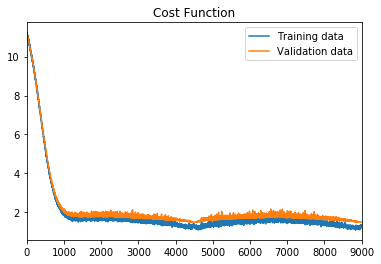

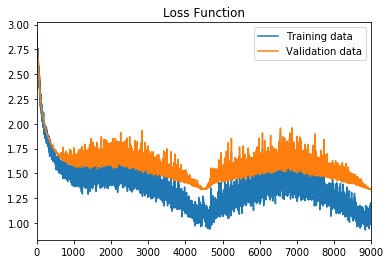

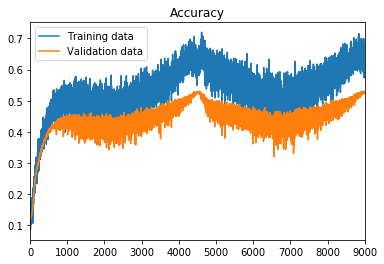

Accuracy on training data: 0.6186444444444444
Accuracy on validation data: 0.5274
Accuracy on test data: 0.5208


In [18]:
#Use partial training data
#X_train, Y_train, Y_train_one_hot, X_val, Y_val, Y_val_one_hot, X_test, Y_test, y_test_one_hot = load_partial_data()

#Use all training data
val_size = 5000
X_train, Y_train, Y_train_one_hot, X_val, Y_val, Y_val_one_hot, X_test, Y_test, y_test_one_hot = load_all_data(val_size)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

#Normalized data
img_trn_nrm = normalize(X_train, mean, std)
img_val_nrm = normalize(X_val, mean, std)
img_test_nrm = normalize(X_test, mean, std)

hidden_nodes = 50 #Hidden nodes
label_count = Y_train_one_hot.shape[1] #Label count
img_dim = img_trn_nrm.shape[1]
layers = [img_dim, hidden_nodes, hidden_nodes, label_count]
e_min = 1e-5
e_max = 1e-1
epsilon = 1e-4
w, b, gamma, beta, mu_av, var_av = initialise_params(hidden_nodes, label_count, img_dim, layers)
imgClassifier = MultiLayerImageClassifier(w, b, e_min, e_max, epsilon, gamma, beta)

# l_min = 0.03614
# l_max = 0.06072
n = img_trn_nrm.shape[0]
n_batch = 100
n_s = 2*np.floor(n/n_batch)
n_epochs = int(n_s * 2 * 2 / n_batch)
#lamda = np.random.uniform(l_min, l_max)
lamda = 0.037802812989809705 #Found using coarse fine search
imgClassifier.mini_batch_gd(n_epochs, n, n_batch, img_trn_nrm, Y_train_one_hot, img_val_nrm, Y_val_one_hot,
                            Y_train, Y_val, n_s, lamda, len(layers))

batch_norm = True
#Accuracy
train_acc = imgClassifier.ComputeAccuracy(img_trn_nrm, Y_train, len(layers), batch_norm)
print('Accuracy on training data: ' + str(train_acc))
val_acc = imgClassifier.ComputeAccuracy(img_val_nrm, Y_val, len(layers), batch_norm)
print('Accuracy on validation data: ' + str(val_acc))
test_acc = imgClassifier.ComputeAccuracy(img_test_nrm, Y_test, len(layers), batch_norm)
print('Accuracy on test data: ' + str(test_acc))

In [205]:
#Compare gradients
reg = 0
eps = 0.001
diff_w = np.zeros(len(layers)-1)
diff_b = np.zeros(len(layers)-1)
grad_w_fast, grad_b_fast = imgClassifier.ComputeGradients(img_trn_nrm[0:1, :], Y_train_one_hot[0:1, :], reg, len(layers))
grad_w_slow, grad_b_slow = imgClassifier.ComputeGradsNumSlow(img_trn_nrm[0:1, :], Y_train_one_hot[0:1, :], reg, len(layers), 1e-7)
for i in range(len(layers)-1):
    diff_w[i] = np.abs(np.sum(grad_w_fast[i]) - np.sum(grad_w_slow[i]))/np.maximum(eps, np.abs(np.sum(grad_w_fast[i])) + np.abs(np.sum(grad_w_slow[i])))
    diff_b[i] = np.abs(np.sum(grad_b_fast[i]) - np.sum(grad_b_slow[i]))/np.maximum(eps, np.abs(np.sum(grad_b_fast[i])) + np.abs(np.sum(grad_b_slow[i])))
print(diff_w)
print(diff_b)

[2.66195404e-07 1.15345442e-07 8.21938900e-08 1.82076576e-03]
[6.48344784e-08 6.43549528e-08 4.51348287e-09 4.44089211e-05]


In [223]:
print(img_trn_nrm.shape[0])

10000
